# Computing with TensorFlow

_Author_: Chris Jewell <c.jewell@lancaster.ac.uk>

_Date_: 2022-03-22

_Copyright_: Chris Jewell 2022


----

This notebook presents a brief introduction to using [TensorFlow](https://tensorflow.org) as a general compute engine for number crunching.  It is written very much from my experience of using the library to implement complex statistical models, and I'll try to highlight features of the library that lead to rapid implementation _and_ rapid runtime.

This guide differs from most other guides and tutorials on [TensorFlow](https://tensorflow.org) by focusing on fundamental computing, such as vectorised and linear algebra, control flow, and automatic parallelisation.  I will _not_ cover use of the high-level machine learning functions provided by Keras, or the probabilistic programming language features provided by [TensorFlow Probability](https://tensorflow.org/probability). 

__Pre-requisites__:

* Familiarity with Python
* Familiarity with Numpy

## What does TensorFlow do?

From the [TensorFlow basics guide](https://www.tensorflow.org/guide/basics): 

> TensorFlow is an end-to-end platform for machine learning. It supports the following:
>
> * Multidimensional-array based numeric computation (similar to NumPy.)
> * GPU and distributed processing
> * Automatic differentiation
> * Model construction, training, and export

TensorFlow allows you to express your computation as a graph, leaving the hardware implementation to the library.  This leads to
* rapid development
* rapid computation
* reduced bugs!

## TensorFlow library structure

TensorFlow provides a rich set of [libraries](https://tensorflow.org/resources/libraries-extensions) that sit on top of the compute layer.  

__NB__: Don't get confused, the Keras ML layer is part of TensorFlow core library!

<div>
<img src="https://gitlab.com/chrism0dwk/practical-epidemics/-/raw/master/site/source/notebooks/TF_diagram.png" width="500" alt="TensorFlow library organisation"/>
</div>

## Installing TensorFlow

TensorFlow has bindings for a wide range of programming languages.  The Python API is most developed, so that is what we will use here.

The latest release version (v2.8.0 as of 2022-03-22) of Tensorflow is best installed using `pip`
```bash
pip install tensorflow
```
with bleeding-edge nightly development versions available too
```bash
pip install tf-nightly
```

__NB__. [Colab](https://colab.research.google.com) users already get TF installed in the standard instance!

## Importing TensorFlow

We can import TensorFlow in the usual Python way, and query the hardware devices available for TF to use

In [1]:
import tensorflow as tf

tf.config.list_logical_devices()

2022-03-23 13:08:03.402679: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-03-23 13:08:03.402708: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: diamond
2022-03-23 13:08:03.402714: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: diamond
2022-03-23 13:08:03.402758: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 465.19.1
2022-03-23 13:08:03.402774: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 465.19.1
2022-03-23 13:08:03.402778: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 465.19.1
2022-03-23 13:08:03.402989: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical oper

[LogicalDevice(name='/device:CPU:0', device_type='CPU')]

## Tensors

TensorFlow operators act on data stored as _Tensors_, which are
* multidimensional arrays containing data _of the same type_
* immutable -- you cannot directly modify them (see later!)

In [2]:
# Skip just to hide library errors if GPU not found
import tensorflow as tf
x = tf.constant(3)

In [3]:
import tensorflow as tf

x = tf.constant([[1., 2., 3.],
                 [4., 5., 6.]])
print(x)

tf.Tensor(
[[1. 2. 3.]
 [4. 5. 6.]], shape=(2, 3), dtype=float32)


### Tensor properties

Tensors have two _important_ properties similar to Numpy arrays:
* `shape` gives the size of the Tensor along each axis
* `dtype` gives the type of the data stored in the Tensor (float32, float64, int32, int64, etc)

In [4]:
print("Data type:", x.dtype)
print("Tensor shape:", x.shape)

Data type: <dtype: 'float32'>
Tensor shape: (2, 3)


## Tensor operations

Tensors may be subject to operations, similar to Numpy arrays.  e.g.

In [5]:
x + 2

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[3., 4., 5.],
       [6., 7., 8.]], dtype=float32)>

In [6]:
x * 6

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 6., 12., 18.],
       [24., 30., 36.]], dtype=float32)>

In [7]:
tf.transpose(x)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1., 4.],
       [2., 5.],
       [3., 6.]], dtype=float32)>

In [8]:
tf.reduce_sum(x)

<tf.Tensor: shape=(), dtype=float32, numpy=21.0>

In [9]:
tf.reduce_sum(x, axis=0) # Reduce over dimension 0, i.e. colsums

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([5., 7., 9.], dtype=float32)>

In [10]:
tf.reduce_sum(x, axis=1) # Reduce over dimension 1, i.e. rowsums

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 6., 15.], dtype=float32)>

## Shape manipulation

Tensor shapes may be manipulated, remembering that elements in the _leftmost_ dimension are stored contiguously in memory.  Reshapes are a fast operation, as only array metadata needs to be updated.

In [11]:
tf.reshape(x, shape=(3, 2))

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1., 2.],
       [3., 4.],
       [5., 6.]], dtype=float32)>

In [12]:
tf.reshape(x, shape=-1) # special notation to `flatten` a Tensor

<tf.Tensor: shape=(6,), dtype=float32, numpy=array([1., 2., 3., 4., 5., 6.], dtype=float32)>

and stacked or concatenated in the normal Numpy way

In [13]:
y = tf.constant([[7., 8., 9.],
                 [10., 11., 12.]])
tf.concat([x, y], axis=0) # concatenate along first dimension

<tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[ 1.,  2.,  3.],
       [ 4.,  5.,  6.],
       [ 7.,  8.,  9.],
       [10., 11., 12.]], dtype=float32)>

In [14]:
tf.stack([x, y], axis=0)  # Stack introduces a new dimension

<tf.Tensor: shape=(2, 2, 3), dtype=float32, numpy=
array([[[ 1.,  2.,  3.],
        [ 4.,  5.,  6.]],

       [[ 7.,  8.,  9.],
        [10., 11., 12.]]], dtype=float32)>

## Tensor `dtype`

When computing with Tensors, `dtype` and `shape` is __everything__!  TensorFlow is _really_ fussy about `dtype` -- there is no automatic type promotion/demotion as in Numpy, R, C++, etc.!  

Fortunately we can control `dtype` when we create a Tensor, such as the following 1-row matrix:

In [15]:
z = tf.constant([[13., 14., 15.]], dtype=tf.float64)

In [16]:
import traceback 

try:
    tf.concat([x, z], axis=0)  # This fails as x.dtype == tf.float32 but z.dtype == tf.float64
except tf.errors.InvalidArgumentError as e:
    print(traceback.format_exc())

Traceback (most recent call last):
  File "/tmp/ipykernel_1278309/1295964305.py", line 4, in <module>
    tf.concat([x, z], axis=0)  # This fails as x.dtype == tf.float32 but z.dtype == tf.float64
  File "/home/jewellcp/Documents/Projects/practical-epidemics/.venv/lib/python3.8/site-packages/tensorflow/python/util/traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/jewellcp/Documents/Projects/practical-epidemics/.venv/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 7186, in raise_from_not_ok_status
    raise core._status_to_exception(e) from None  # pylint: disable=protected-access
tensorflow.python.framework.errors_impl.InvalidArgumentError: cannot compute ConcatV2 as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:ConcatV2] name: concat



This operation failed because `x.dtype == tf.float32` but `z.dtype == tf.float64`.  If needs be, we can cast Tensors to different `dtypes`

In [17]:
tf.concat([tf.cast(x, z.dtype),  # works, as we cast x to z's `dtype`
           z],
          axis=0)

<tf.Tensor: shape=(3, 3), dtype=float64, numpy=
array([[ 1.,  2.,  3.],
       [ 4.,  5.,  6.],
       [13., 14., 15.]])>

though generally this should be avoided if possible as it hurts performance.

## Tensor `shape`

Tensor `shape` is equally important.  Shapes of binary operators must be _compatible_ -- they must obey [Numpy broadcasting rules](https://numpy.org/doc/stable/user/basics.broadcasting.html).

For example this raises an `InvalidArgumentError`, because `x.shape = (2, 3)` is not compatible with `y.shape == (2,)`

In [18]:
x = tf.constant([[1., 2., 3.],
                 [4., 5., 6.]])
y = tf.constant([7., 8.])
try:
    x * y
except tf.errors.InvalidArgumentError:
    print(traceback.format_exc())

Traceback (most recent call last):
  File "/tmp/ipykernel_1278309/969305608.py", line 5, in <module>
    x * y
  File "/home/jewellcp/Documents/Projects/practical-epidemics/.venv/lib/python3.8/site-packages/tensorflow/python/util/traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/jewellcp/Documents/Projects/practical-epidemics/.venv/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 7186, in raise_from_not_ok_status
    raise core._status_to_exception(e) from None  # pylint: disable=protected-access
tensorflow.python.framework.errors_impl.InvalidArgumentError: Incompatible shapes: [2,3] vs. [2] [Op:Mul]



### Broadcasting

But [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html) allows us to automatically operate on different shapes, provided the shapes broadcast together.  This allows some _incredibly_ concise code to express computations which in other languages would be more verbose.

For example, I can calculate the outer product of two vectors by altering their shapes to 1-column and 1-row matrices respectively:

In [19]:
a = tf.range(5)  # [0, 1, 2, 3, 4]
b = tf.range(5, 10)  # [5, 6, 7, 8, 9]

a[:, tf.newaxis] * b[tf.newaxis, :]

<tf.Tensor: shape=(5, 5), dtype=int32, numpy=
array([[ 0,  0,  0,  0,  0],
       [ 5,  6,  7,  8,  9],
       [10, 12, 14, 16, 18],
       [15, 18, 21, 24, 27],
       [20, 24, 28, 32, 36]], dtype=int32)>

For more information, see the [TensorFlow basics guide](https://www.tensorflow.org/guide/tensor#about_shapes).

## Indexing Tensors

Indexing is an extensive topic, and readers are referred to the [TensorFlow Tensor Slicing Guide](https://www.tensorflow.org/guide/tensor_slicing) for an extensive discussion.

Tensors may be indexed using Numpy-style integer or slice notation:

In [20]:
x = tf.constant([[1., 2., 3., 4.],
                 [5., 6., 7., 8.],
                 [9., 10., 11., 12.]])
print("Extract x[2, 2]", x[2, 2])
print("Extract row 1:", x[1, :])
print("Extract columns 2 and 3", x[:, 2:4])


Extract x[2, 2] tf.Tensor(11.0, shape=(), dtype=float32)
Extract row 1: tf.Tensor([5. 6. 7. 8.], shape=(4,), dtype=float32)
Extract columns 2 and 3 tf.Tensor(
[[ 3.  4.]
 [ 7.  8.]
 [11. 12.]], shape=(3, 2), dtype=float32)


However, indexing using Tensors of indices will not work

In [21]:
col_idx = tf.constant([0, 2, 3])
try:
    x[:, col_idx]
except TypeError:
    print(traceback.format_exc())

Traceback (most recent call last):
  File "/tmp/ipykernel_1278309/201978485.py", line 3, in <module>
    x[:, col_idx]
  File "/home/jewellcp/Documents/Projects/practical-epidemics/.venv/lib/python3.8/site-packages/tensorflow/python/util/traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/jewellcp/Documents/Projects/practical-epidemics/.venv/lib/python3.8/site-packages/tensorflow/python/ops/array_ops.py", line 899, in _check_index
    raise TypeError(_SLICE_TYPE_ERROR + ", got {!r}".format(idx))
TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got <tf.Tensor: shape=(3,), dtype=int32, numpy=array([0, 2, 3], dtype=int32)>



### `tf.gather` and `tf.gather_nd`

Instead of list indexing, we can use `tf.gather` to index on a single dimension, for example to extract columns:

In [22]:
tf.gather(x, indices=col_idx, axis=1)  

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 1.,  3.,  4.],
       [ 5.,  7.,  8.],
       [ 9., 11., 12.]], dtype=float32)>

or to gather specific indices

In [23]:
indices = tf.constant([[0, 1], [2, 3], [0, 0]])
tf.gather_nd(x, indices=indices)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 2., 12.,  1.], dtype=float32)>

## Updating Tensors

Tensors are immutable -- we cannot assign to arbitrary elements like we can with Numpy.  So, for example,

In [24]:
try:
    x[2, 3] = 16.0
except TypeError as e:
    print(e)

'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment


raises a `TypeError`.

Instead, however, we can use the `tf.tensor_scatter_nd_*` functions to add, subtract, or replace elements.  So our example should be

In [25]:
new_x = tf.tensor_scatter_nd_update(x, indices=[[2, 3]], updates=[16.0])

__NB__ `tf.tensor_scatter_nd_update` returns a new `new_x`, but wherever possible the memory belonging to the old `x` will be reused to avoid unnecessary copying of data.

## Converting between TensorFlow and Numpy

TensorFlow allows conversion to and from Numpy arrays using `tf.convert_to_tensor` and `Tensor.numpy()` respectively

In [26]:
import numpy as np

foo = np.random.uniform(size=[2,3])

foo_tf = tf.convert_to_tensor(foo)
bar_tf = tf.math.log(foo_tf)

bar_tf.numpy()

array([[-1.78708352, -1.6118898 , -0.10471066],
       [-3.53953039, -0.41078817, -0.5490035 ]])

## Computing gradients

One of the most powerful features of Tensorflow is Autodiff.  Gradients may be calculated using the `tf.GradientTape` context manager.

The Gradient Tape records the operations performed in a particular calculation, enabling [back-propagation](https://en.wikipedia.org/wiki/Backpropagation) auto-differentiation.

For example, to record
$$\frac{\mathrm{d} x^2}{\mathrm{d} x} = 2x$$
we first record the tape

In [27]:
x = tf.constant(3.0)

with tf.GradientTape() as tape:
    tape.watch(x)
    y = x**2

then use it to calculate our required gradient

In [28]:
tape.gradient(target=y, sources=x)

<tf.Tensor: shape=(), dtype=float32, numpy=6.0>

## Functions

Tensors can be used -- and are encouraged to be used -- inside functions.  For example, let's calculate the pair-wise distance between all points in a set of 2D coordinates.

In [29]:
def pairwise_distance(x_coords, y_coords):
    x_coords = tf.convert_to_tensor(x_coords) # Good idea to ensure we have Tensors!
    y_coords = tf.convert_to_tensor(y_coords)
    dx = x_coords[:, tf.newaxis] - x_coords[tf.newaxis, :]
    dy = y_coords[:, tf.newaxis] - y_coords[tf.newaxis, :]
    return tf.sqrt(dx*dx + dy*dy)

x_coords = tf.random.uniform(shape=[100])
y_coords = tf.random.uniform(shape=[100])

d = pairwise_distance(x_coords, y_coords)
d.shape

TensorShape([100, 100])

## Loops

Loops are implemented using the `tf.while_loop` operation.  This operation requires a _functional_ approach to programming, where we loop along a pre-specified tensor until a stopping criterion is met.

We'll use `tf.while_loop` to implement an iterative Geometric random variable sampler.  A Geometric random variable represents the number of weighted coin tosses required to get the first heads up.  Our loop repeatedly tosses a weighted coin, accumulating the number of iterations until the coin comes up heads

In [30]:
prob = tf.constant(0.01)  # Probability of a heads up

def loop_body(num_tosses, stop):  # loop_body takes same arguments as return values
    u = tf.random.uniform(shape=[1])
    must_stop = u < prob
    return num_tosses+1, must_stop

def loop_cond(num_tosses, stop):  # loop_condition returns False to break the loop
    return tf.math.logical_not(stop)

num_tosses, _ = tf.while_loop(cond=loop_cond, body=loop_body, loop_vars=(0, False))
num_tosses

<tf.Tensor: shape=(), dtype=int32, numpy=411>

## Conditionals

Since TensorFlow is targeted at _vector_ processors, conditionals can seem a little weird.  However, really they are just following functional programming patterns.

* `tf.cond`
* `tf.switch_case`
* `tf.where`

### Selecting behaviour

`tf.cond` allows selecting a behaviour based on a _scalar_ condition.  We define `true_fn` and `false_fn` functions, which take no arguments and return _exactly_ the `Tensorspec` (i.e. shape and dtype)

In [31]:
def true_fn():
    return tf.constant(1)

def false_fn():
    return tf.constant(0)

tf.cond(tf.random.uniform(shape=[1]) < 0.5, true_fn, false_fn)

<tf.Tensor: shape=(), dtype=int32, numpy=0>

### Selecting a function to run based on index

`tf.switch_case` allows us to select a particular function from a list based on an enumeration (see also `tf.case`):

In [32]:
def fn0(): return tf.constant(0)
def fn1(): return tf.constant(1)
def fn2(): return tf.constant(2)

branch_to_call = tf.constant(1)
tf.switch_case(branch_to_call, branch_fns=(fn0, fn1, fn2))

<tf.Tensor: shape=(), dtype=int32, numpy=1>

### Selecting values from vectors

`tf.where` allows us to select elements from one of two vectors depending on an element-wise criterion

In [33]:
true_vals = tf.constant([1., 2., 3., 4.])
false_vals = -true_vals

selector = tf.random.uniform(shape=true_vals.shape) < 0.5
vals = tf.where(selector, true_vals, false_vals)

print("selector:", selector.numpy())
print("vals:", vals.numpy())

selector: [False  True False  True]
vals: [-1.  2. -3.  4.]


__NB__ a common pattern in vectorised programming is to compute *all* branches, and then use `tf.where` to select the relevant results.

## Graph mode

So far, we have run all our code in "Eager mode" where all commands are run on the fly just like regular Numpy.  The real power of TensorFlow is when we run computations in "Graph mode".

Graph mode is enabled by decorating our function with `@tf.function`, e.g. our Geometric function from earlier

In [34]:
@tf.function
def matrix_sq(x):
    x = tf.convert_to_tensor(x)
    return tf.linalg.matmul(x, x, transpose_a=True)

x = np.random.uniform(size=(5000, 5000))
z = matrix_sq(x)

2022-03-23 13:08:04.660916: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 200000000 exceeds 10% of free system memory.
2022-03-23 13:08:04.772051: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 200000000 exceeds 10% of free system memory.
2022-03-23 13:08:04.884634: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 200000000 exceeds 10% of free system memory.


### Function tracing

In Graph mode, operations within functions are first _traced_, and assembled into a directed acyclic graph.  Tracing only happens _once_ per function as long as its arguments stay the same.  

This means that Python functions are (typically) only run during tracing, and are excluded when the compiled graph is run.  This is particularly true for `print` statements.  For example

In [35]:
@tf.function
def add_one(x):
    print("Adding to ", x)
    return x

print("First call:",  add_one(5)) # Graph is traced, so `print` is called
print("Second call:", add_one(5)) # Graph already exists for this function, no tracing is done

Adding to  5
First call: tf.Tensor(5, shape=(), dtype=int32)
Second call: tf.Tensor(5, shape=(), dtype=int32)


but if we change the argument, the function is re-traced:

In [36]:
print("Third call:", add_one(6))

Adding to  6
Third call: tf.Tensor(6, shape=(), dtype=int32)


To prevent re-tracing, we can specify the argument as a `tf.Tensor`

In [37]:
print("Fourth call:", add_one(tf.constant(7)))  # tracing occurs
print("Fifth call:", add_one(tf.constant(8)))   # no tracing

Adding to  Tensor("x:0", shape=(), dtype=int32)
Fourth call: tf.Tensor(7, shape=(), dtype=int32)
Fifth call: tf.Tensor(8, shape=(), dtype=int32)


### Printing within a graph-mode function

Notice that in "Fourth call" above, printing `x` (a Tensor) simply provides an empty `TensorSpec` with shape and `dtype` information but no actual value.  This is because `print` is only called during tracing _before_ the graph-mode function has been called with its actual value.  

To print the actual value of a Tensor, use `tf.print` which is a TF operation and is compiled into the graph.  This can be useful for debugging.  

In [38]:
@tf.function
def add_oneV2(x):
    tf.print("Adding to ", x)
    return x

print("Sixth call:", add_oneV2(tf.constant(9)))  # `tf.print` returns value of `x`
print("Seventh call:", add_oneV2(tf.constant(10))) # `tf.print` returns value of `x`

Adding to  9
Sixth call: tf.Tensor(9, shape=(), dtype=int32)
Adding to  10
Seventh call: tf.Tensor(10, shape=(), dtype=int32)


### Why graph mode

Using graph mode, we give TensorFlow the opportunity to speed up our code by performing optimisations on our function, such as pre-computing constant values and fusing operations.  This is most effective on functions that require lots of smaller operations rather than one big one.  Therefore, we do not expect `tf.function` to accelerate a single call to, say, `tf.linalg.matmul`.

__Limitations__:
* Graph-compiled functions _must_ only return Tensors, or lists/tuples/dicts of Tensors!
* For very short functions, graph compilation overhead may outweigh the computational gains.
* Tracing is expensive: occasionally it is difficult to avoid.

## Just in time compilation

TensorFlow provides a _just-in-time_ (JIT) compiler, [XLA](https://tensorflow.org/xla).  XLA provides an extreme level of optimisation, effectively compiling our Python code into low-level bytecode for rapid execution.  We can switch XLA on just as easily

In [39]:
@tf.function(jit_compile=True)
def matrix_sq(x):
    x = tf.convert_to_tensor(x)
    return tf.linalg.matmul(x, x, transpose_a=True)

x = np.random.uniform(size=(5000, 5000))
z = matrix_sq(x)

2022-03-23 13:08:07.281624: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 200000000 exceeds 10% of free system memory.
2022-03-23 13:08:07.439877: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 200000000 exceeds 10% of free system memory.
2022-03-23 13:08:07.525500: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x55652302d260 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-03-23 13:08:07.525519: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): Host, Default Version
2022-03-23 13:08:07.532936: I tensorflow/compiler/jit/xla_compilation_cache.cc:399] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


### Limitations of XLA

In addition to Graph-mode limitations, XLA has a number of further limitations:
* the shapes of _all_ data structures must be known at compile time
* XLA-compiled functions must be _pure_
  * no side-effects, e.g. IO, printing, etc
  
Some TensorFlow operations are not available, e.g. `tf.sparse` operations, `tf.print`.

## Worked example in epidemics

To demonstrate the capabilities of TensorFlow in action, we'll use the example of a discrete-time "SIR" epidemic model simulation.  This simulation evolves the system through time, with Susceptible individuals transitioning to Infected, and Infected individuals transitioning to Removed.

<div>
<img src="https://gitlab.com/chrism0dwk/practical-epidemics/-/raw/master/site/source/notebooks/sir_diagram.png" width="500" alt="TensorFlow library organisation"/>
</div>

Given initial conditions $t=0$, $S_0 = 120000$, $I_0=1$, $R_0=0$, we can evolve the system discrete timesteps (of length 1) by

1. Drawing new transition events
$$y_{SI} \sim Binomial(S_t, 1 - e^{-\beta I_t}) \\ y_{IR} \sim Binomial(I_t, 1 - e^{-\gamma})$$

2. Updating the states and time
$$S_{t+1} = S_t - y_{SI} \\ I_{t+1} = I_t + y_{SE} - y_{IR} \\ R_{t+1} = R_{t}+ y_{IR} \\ t:=t+1$$

3. Goto 1 while $t < 200$

## TensorFlow implementation

To implement our simulation, we need to make use of vectorized operations and linear algebra where we can.  What follows is my personal preferred pattern for this problem!

First define the state transition model and event rates

In [40]:
# Define the SIR model using stoichiometry matrix 
#                          SI  IR 
sir_stoich = tf.constant([[-1,  0],  # S
                          [ 1, -1],  # I
                          [ 0,  1]], # R
                         dtype=np.float32)


def make_transition_rate_fn(beta, gamma):  # Closures are a common pattern
    """S->I and I->R transitions"""
    def fn(state):
            return tf.stack([
                    beta * state[1] / tf.reduce_sum(state),  # Infection rate
                    gamma                                    # Recovery rate
                ],
                axis=0
            )
    return fn


# Set initial state
initial_state = np.array([120000, 1, 0], dtype=np.float32)

# Set the parameters
transition_rate_fn = make_transition_rate_fn(beta=0.3, gamma=0.14)

Now define the actual simulation loop, with random number seed propagation

In [41]:
import tensorflow_probability as tfp
from tensorflow_probability.python.internal import samplers
tfd = tfp.distributions

def simulation(initial_state, transition_rate_fn, stoichiometry, num_steps, seed=0):
    seed = samplers.sanitize_seed(seed)
    
    def one_step(seed_and_state, _):  # Timestep index is ignored
        seed, state = seed_and_state
        seed0, next_seed = samplers.split_seed(seed, salt="one_step") # Split seed
        
        # Calculate transition probabilities
        rates = transition_rate_fn(state)
        probs = 1.0 - tf.math.exp(-rates)
        
        # Draw increments, batching together S->I and I->R
        increments = tfd.Binomial(total_count=state[:2],  # Select (S, I), R is irrelevant
                                  probs=probs).sample(seed=seed0)
        
        # Calculate new state
        new_state = state + tf.linalg.matvec(stoichiometry, increments)
        
        return next_seed, new_state
    
    # tf.scan iteratively applies one_step (uses tf.while_loop)
    _, simulation = tf.scan(fn=one_step,
                            elems=tf.range(200),  # Run for 200 steps
                            initializer=(seed, initial_state))
    
    return simulation

and a plotting function for our output

In [42]:
def plot_sir(sim):
    plt.plot(sim[:, 0], label="Susceptible")
    plt.plot(sim[:,1], label="Infected")
    plt.plot(sim[:, 2], label="Removed")
    plt.xlabel("Time/days")
    plt.ylabel("Number of individuals")
    plt.legend()
    return None

def time_this(fn):
    """Timing decorator using time.perf_counter"""
    def wrapper(*args, **kwargs):
        start = time.perf_counter()
        rv = fn(*args, **kwargs)
        end = time.perf_counter()
        print("Elapsed wallclock time:", end-start, "seconds")
        return rv
    return wrapper

Run the simulation in (default) Eager model, and plot the output

Elapsed wallclock time: 0.7186074089840986 seconds


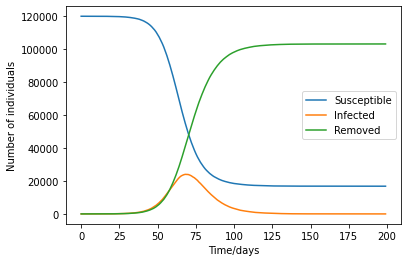

In [43]:
import matplotlib.pyplot as plt
import time
    
@time_this
def eager_mode():
  return simulation(initial_state=initial_state, 
                    transition_rate_fn=transition_rate_fn,
                    stoichiometry=sir_stoich,
                    num_steps=200, 
                    seed=[4,2])
sim = eager_mode()
plot_sir(sim.numpy())

### Simulate in graph mode

In graph mode, we get a speedup on the _second_ call to `simulate`.  This is because on the first call, we incur a graph compilation overhead.  However, with a compiled graph we get a 10x speedup!

In [44]:
@time_this
@tf.function
def graph_mode():
    return simulation(initial_state=initial_state, 
                      transition_rate_fn=transition_rate_fn,
                      stoichiometry=sir_stoich,
                      num_steps=200, 
                      seed=[2,2])

sim = graph_mode()
sim = graph_mode()

Elapsed wallclock time: 0.35742090101120993 seconds
Elapsed wallclock time: 0.011307230975944549 seconds


### Simulate in XLA mode

In XLA mode, we incur a large compilation overhead, but get an even faster function on the second call -- approximately a 500x speedup compared to Eager mode!

In [45]:
@time_this
@tf.function(jit_compile=True)
def xla_mode():
    return simulation(initial_state=initial_state, 
                      transition_rate_fn=transition_rate_fn,
                      stoichiometry=sir_stoich,
                      num_steps=200, 
                      seed=[2,2])

sim = xla_mode()
sim = xla_mode()

2022-03-23 13:08:11.248248: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:237] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


Elapsed wallclock time: 1.800255890993867 seconds
Elapsed wallclock time: 0.0005566269974224269 seconds


## Remarks and conclusions

For large computationally-intensive problems, TensorFlow provides an interesting framework for vectorised computation, autodiff, and hardware agnostic computing.  

Graph mode and XLA mode are useful, _provided_:
* Problem sizes are large
* Problems are complex
* Large graphs of operations are required

Limitations in Graph mode and XLA require careful thought for some algorithms, however.  My advice is to try to replace conditionals (e.g. `np.where`, `if`/`else`, etc) with mathematical operations (e.g. multiply by 0 or 1) wherever possible.

Decomposing problems in terms of _linear algebra_ leads to more concise code and (more often than not) improved runtime. 

## Where next?
I would recommend

1. Reading the API docs at https://tensorflow.org/api_docs
    * `tf.linalg`
    * `tf.sparse`
    * `tf.math`...

2. Read the TensorFlow guide at https://tensorflow.org/guide

3. Profiling with TensorBoard at https://www.tensorflow.org/tensorboard

4. Machine learning library, `keras`, provides Neural Net building blocks

5. [TensorFlow Probability](https://tensorflow.org/probability) provides probabilistic programming

6. Let's open a discussion in the RSN Team!